In [1]:
from Bio import PDB
from Bio.PDB import Superimposer
from Bio.PDB import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
import os
import csv
import pandas as pd
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import math

C:\Users\lilli\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def get_secondary_structure(structure, fp):
    model = structure[0]  # Assuming single model
    dssp = DSSP(model, fp)  # You need the actual file path for DSSP
    return {residue: dssp[key][2] for key, residue in dssp.keys()}

In [5]:
def calculate_rmsd(fixed_atoms, moving_atoms, structure):
    super_imposer = Superimposer()
    super_imposer.set_atoms(fixed_atoms, moving_atoms)
    super_imposer.apply(structure.get_atoms())
    return super_imposer.rms

In [6]:
p = PDB.PDBParser(QUIET=True)
pdb_directory = "output_lilli/"
ref_structure = p.get_structure('fixed', 'SARS-CoV-ACE2_residues.pdb')

In [6]:
crystal_structure = p.get_structure('crystal', '6m0j.pdb')
crys_model = crystal_structure[0]

for chain in crys_model:
    if chain.id == 'E':
        fixed_crys_atoms = [residue['CA'] for residue in chain.get_residues() if 'CA' in residue]
        moving_ref_atoms = [residue['CA'] for residue in ref_structure.get_residues() if 'CA' in residue]
        print(len(fixed_crys_atoms), len(moving_ref_atoms))
        moving_ref_atoms.pop()
        assert len(fixed_crys_atoms) == len(moving_ref_atoms)
        rmsd = calculate_rmsd(fixed_crys_atoms, moving_ref_atoms, chain)
        print(rmsd)


194 195
18.957933346331075


In [8]:
from tmtools.io import get_structure, get_residue_data
from tmtools import tm_align
ref_s = get_structure('SARS-CoV-ACE2_residues.pdb')
chain = next(ref_s.get_chains())
ref_coords, ref_seq = get_residue_data(chain)

In [27]:
import os
import pandas as pd
from Bio import PDB

def calculate_average_b_factor(structure):
    len_prot = [atom for residue in structure.get_residues() for atom in residue]
    bfactor = sum(atom.get_bfactor() for model in structure for chain in model for residue in chain for atom in residue)
    return bfactor / len(len_prot)

def get_amino_acids(structure):
    amino_acids = set()
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and residue.id[2] == ' ':
                    amino_acids.add(residue.get_resname())
    return amino_acids

def create_amino_acid_changes_matrix(pdb_directory):
    parser = PDB.PDBParser(QUIET=True)
    amino_acids = set()

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            amino_acids.update(get_amino_acids(structure))

    amino_acids = sorted(amino_acids)

    df_BF = pd.DataFrame(index=amino_acids, columns=amino_acids)

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            old_aa = None
            for model in structure:
                for chain in model:
                    for residue in chain:
                        if residue.id[0] == ' ' and residue.id[2] == ' ':
                            new_aa = residue.get_resname()
                            if old_aa is not None and new_aa != old_aa:
                                bfactor = calculate_average_b_factor(structure)
                                df_BF.loc[old_aa, new_aa] = bfactor
                            old_aa = new_aa

    return df_BF

# Specify the directory containing your PDB files
pdb_directory = 'output_lilli/'

# Create the amino acid changes matrix
df_amino_acid_changes = create_amino_acid_changes_matrix(pdb_directory)
print(df_amino_acid_changes)



           ALA        ARG        ASN        ASP        CYS        GLN  \
ALA        NaN  43.222916  22.644127    24.8875  26.554966  39.934753   
ARG  43.222916        NaN  43.222916  34.145804  43.222916    24.8875   
ASN  22.863403  22.863403        NaN  22.863403    24.8875  39.934753   
ASP  46.255425  43.222916  22.644127        NaN  46.255425  39.934753   
CYS  26.554966  43.222916  22.863403  46.255425        NaN  26.554966   
GLN  23.936385  43.222916  39.934753  39.934753  39.934753        NaN   
GLU  45.343191  22.863403  22.644127  84.062727  45.343191  39.934753   
GLY  23.980204  43.222916    24.8875  22.863403  22.863403    24.8875   
HIS  22.863403  20.142327  20.142327  20.142327  20.142327  39.934753   
ILE  22.863403  25.094095  22.644127  46.440253  46.440253  39.934753   
LEU  57.734968  43.222916  22.863403  22.863403    24.8875  22.863403   
LYS  49.320905    24.8875  22.644127  49.320905  22.863403  39.934753   
MET  40.411322  40.411322  40.411322  40.411322  40

In [12]:
import os
import pandas as pd
from Bio import PDB
from tmtools.io import get_structure, get_residue_data
from tmtools import tm_align
import numpy as np

def get_amino_acids(structure):
    amino_acids = set()
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and residue.id[2] == ' ':
                    amino_acids.add(residue.get_resname())
    return amino_acids

def create_amino_acid_changes_matrix(pdb_directory):
    parser = PDB.PDBParser(QUIET=True)
    amino_acids = set()

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            amino_acids.update(get_amino_acids(structure))
            
    amino_acids = sorted(amino_acids)

    df_BF = pd.DataFrame(index=amino_acids, columns=amino_acids)

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            
            chain = next(structure.get_chains())
            coords, seq = get_residue_data(chain)

            old_aa = None
            for model in structure:
                for chain in model:
                    for residue in chain:
                        if residue.id[0] == ' ' and residue.id[2] == ' ':
                            new_aa = residue.get_resname()
                            if old_aa is not None and new_aa != old_aa:
                                #bfactor = calculate_average_b_factor(structure)
                                
                                res = tm_align(ref_coords, coords, ref_seq, seq)
                                tm_score = res.tm_norm_chain1
                                #len_prot = [atom for residue in structure.get_residues() for atom in residue]
                                #average_tm_score = tm_score / len(len_prot)
                                
                                #df_BF.loc[old_aa, new_aa] = average_tm_score
                                df_BF.loc[old_aa, new_aa] = tm_score
                            old_aa = new_aa

    return df_BF

# Specify the directory containing your PDB files
pdb_directory = 'output_lilli/'

# Create the amino acid changes matrix
df_amino_acid_changes = create_amino_acid_changes_matrix(pdb_directory)
print(df_amino_acid_changes)


          ALA       ARG       ASN       ASP       CYS       GLN       GLU  \
ALA       NaN  0.187454  0.255288  0.279718  0.228699  0.231611  0.142677   
ARG  0.187454       NaN  0.187454  0.284754  0.187454  0.279718  0.209238   
ASN    0.4089    0.4089       NaN    0.4089  0.279718  0.231611  0.255288   
ASP  0.196254  0.187454  0.255288       NaN  0.196254  0.231611    0.4089   
CYS  0.228699  0.187454    0.4089  0.196254       NaN  0.228699  0.142677   
GLN  0.420881  0.187454  0.231611  0.231611  0.231611       NaN  0.231611   
GLU  0.142677    0.4089  0.255288  0.150588  0.142677  0.231611       NaN   
GLY   0.28271  0.187454  0.279718    0.4089    0.4089  0.279718  0.279718   
HIS    0.4089  0.318313  0.318313  0.318313  0.318313  0.231611  0.318313   
ILE    0.4089  0.252654  0.255288  0.211072  0.211072  0.231611  0.211072   
LEU  0.231395  0.187454    0.4089    0.4089  0.279718    0.4089  0.231395   
LYS  0.171005  0.279718  0.255288  0.171005    0.4089  0.231611  0.171005   

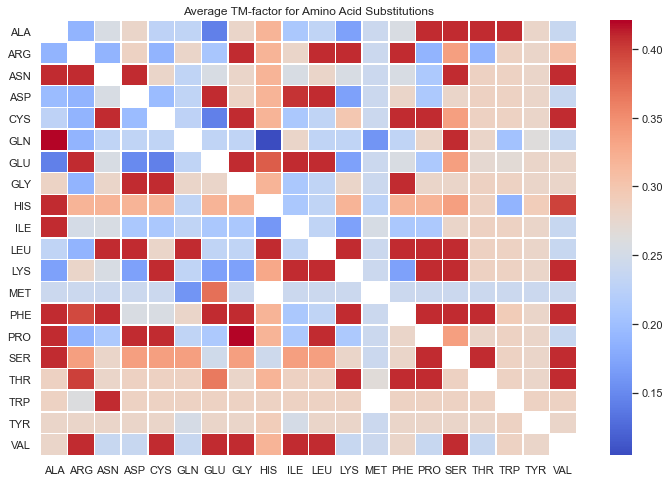

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_amino_acid_changes is your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot heatmap without numerical annotations
sns.heatmap(df_amino_acid_changes.astype(float), annot=False, cmap="coolwarm", linewidths=.5)

plt.title('Average TM-factor for Amino Acid Substitutions')
plt.show()


In [25]:
len_prot = [atom for residue in ref_structure.get_residues() for atom in residue]
bfactor = 0
for model in ref_structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                bf = atom.get_bfactor()
                bfactor += bf
bfactor = bfactor / len(len_prot)
print(bfactor)

23.304115359688907
